<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo_37/blob/main/RETO/Subterraneas_EDA_Entrega_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciencia y analítica de datos
Profesor: Dr. María de la Paz Rico Fernandez

#RETO:Clasificación de aguas Subterráneas
## Entrega 2
_18 de Noviembe de 2022_
# Equipo 37
>Karina Zafra Vallejo           A01793979

>Francisco Javier Parga García  A01794380

In [1]:
!pip install geopandas qeds missingno -q

     |████████████████████████████████| 1.0 MB 19.6 MB/s 
     |████████████████████████████████| 6.3 MB 31.3 MB/s 
     |████████████████████████████████| 16.7 MB 892 kB/s 
     |████████████████████████████████| 179 kB 41.7 MB/s 


In [2]:
#cargamos las librerías

# Para omitir los mensajes de warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import time
from collections import Counter

import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

# Carga de datos

In [3]:
#la ruta donde se encuentra el archivo
subterranea="https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-equipo_37/main/RETO/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv"
df_sub = pd.read_csv(subterranea, encoding='cp1252')
df_sub.columns

Index(['CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO',
       'ACUIFERO', 'SUBTIPO', 'LONGITUD', 'LATITUD', 'PERIODO', 'ALC_mg/L',
       'CALIDAD_ALC', 'CONDUCT_mS/cm', 'CALIDAD_CONDUC', 'SDT_mg/L',
       'SDT_M_mg/L', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'FLUORUROS_mg/L',
       'CALIDAD_FLUO', 'DUR_mg/L', 'CALIDAD_DUR', 'COLI_FEC_NMP/100_mL',
       'CALIDAD_COLI_FEC', 'N_NO3_mg/L', 'CALIDAD_N_NO3', 'AS_TOT_mg/L',
       'CALIDAD_AS', 'CD_TOT_mg/L', 'CALIDAD_CD', 'CR_TOT_mg/L', 'CALIDAD_CR',
       'HG_TOT_mg/L', 'CALIDAD_HG', 'PB_TOT_mg/L', 'CALIDAD_PB', 'MN_TOT_mg/L',
       'CALIDAD_MN', 'FE_TOT_mg/L', 'CALIDAD_FE', 'SEMAFORO', 'CONTAMINANTES',
       'CUMPLE_CON_ALC', 'CUMPLE_CON_COND', 'CUMPLE_CON_SDT_ra',
       'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO', 'CUMPLE_CON_DUR',
       'CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS', 'CUMPLE_CON_CD',
       'CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB', 'CUMPLE_CON_MN',
       'CUMPLE_CON_FE'],
      dtype='

In [4]:
#vamos a ver el tamaño de la base de datos
df_sub.shape

(1068, 57)

Eliminación de caracteres en columnas flotantes

In [5]:
for colum in list(df_sub.columns):
  
  try:
    df_sub[colum] = df_sub[colum].str.replace('<', '', regex=True) #Reemplazar valores con <
    df_sub[colum] = df_sub[colum].str.replace('=', '', regex=True) #Reemplazar valores con =

    try:
      df_sub[colum] = df_sub[colum].astype(float) #Convertir columas a flotantes
      
    except:
      pass

  except:
    pass

  df_sub[colum] = pd.to_numeric(df_sub[colum], errors='coerce').fillna(df_sub[colum]) #Convertir columas a Numericos

In [6]:
df_sub.describe().T

,count,mean,std,min,25%,50%,75%,max
LONGITUD,1068.0,-101.891007,6.703263,-116.66425,-105.388865,-102.174180,-98.974716,-86.864120
LATITUD,1068.0,23.163618,3.887670,14.56115,20.212055,22.617190,25.510285,32.677713
PERIODO,1068.0,2020.000000,0.000000,2020.00000,2020.000000,2020.000000,2020.000000,2020.000000
ALC_mg/L,1064.0,235.633759,116.874291,26.64000,164.000000,215.527500,292.710000,1650.000000
CONDUCT_mS/cm,1062.0,1138.953013,1245.563674,50.40000,501.750000,815.000000,1322.750000,18577.000000
SDT_mg/L,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SDT_M_mg/L,1066.0,896.101567,2751.530590,25.00000,337.500000,550.400000,916.100000,82170.000000
FLUORUROS_mg/L,1068.0,1.075600,1.924278,0.20000,0.267175,0.503500,1.139850,34.803300
DUR_mg/L,1067.0,347.938073,359.669452,20.00000,121.194800,245.335800,453.930000,3810.692200
COLI_FEC_NMP/100_mL,1068.0,355.490356,2052.457014,1.10000,1.100000,1.100000,13.250000,24196.000000


In [7]:
df_sub.describe(include='object').T

,count,unique,top,freq
CLAVE,1068,1068,DLAGU6,1
SITIO,1068,1066,EL FUERTE,2
ORGANISMO_DE_CUENCA,1068,13,CUENCAS CENTRALES DEL NORTE,232
ESTADO,1068,32,DURANGO,121
MUNICIPIO,1068,452,LA PAZ,27
ACUIFERO,1068,273,PENINSULA DE YUCATAN,119
SUBTIPO,1068,8,POZO,1039
CALIDAD_ALC,1064,4,Alta,794
CALIDAD_CONDUC,1062,5,Permisible para riego,460
CALIDAD_SDT_ra,1066,5,Excelente para riego,491


## Seleccion de columnas categóricas

In [8]:
#para separar todas las categóricas
categorical_columns = [col for col in df_sub.columns if df_sub[col].dtypes == object]

#para separar las categóricas sin incluir CLAVE
#categorical_columns = [col for col in df_sub.columns if df_sub[col].dtypes == object][1:0]

print(len(categorical_columns), categorical_columns)

39 ['CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO', 'ACUIFERO', 'SUBTIPO', 'CALIDAD_ALC', 'CALIDAD_CONDUC', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'CALIDAD_FLUO', 'CALIDAD_DUR', 'CALIDAD_COLI_FEC', 'CALIDAD_N_NO3', 'CALIDAD_AS', 'CALIDAD_CD', 'CALIDAD_CR', 'CALIDAD_HG', 'CALIDAD_PB', 'CALIDAD_MN', 'CALIDAD_FE', 'SEMAFORO', 'CONTAMINANTES', 'CUMPLE_CON_ALC', 'CUMPLE_CON_COND', 'CUMPLE_CON_SDT_ra', 'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO', 'CUMPLE_CON_DUR', 'CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS', 'CUMPLE_CON_CD', 'CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB', 'CUMPLE_CON_MN', 'CUMPLE_CON_FE']


## Seleccion de columnas numéricas

In [9]:
float_columns = [col for col in df_sub.columns if df_sub[col].dtypes != object]
print(len(float_columns), float_columns)

18 ['LONGITUD', 'LATITUD', 'PERIODO', 'ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_mg/L', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CD_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L']


## Balance de categorias

In [10]:
#Lista de semaforo
df_sub['SEMAFORO'].unique().tolist()

['Verde', 'Rojo', 'Amarillo']

Conteo de datos deacuerdo a su etiqueta de semaforo

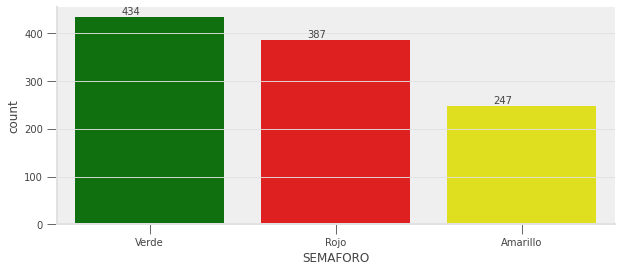

In [11]:
color_list = ['green','red', 'yellow']

fig, ax = plt.subplots(figsize=(10,4))

ax = sns.countplot(data=df_sub, x='SEMAFORO',  palette=color_list)

for p in ax.patches:
  ax.annotate(p.get_height(), (p.get_x()+0.25,p.get_height()+5))

plt.show()

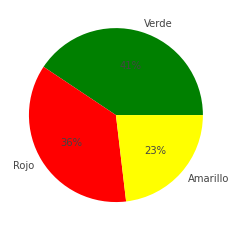

In [12]:
semaforo = Counter(df_sub['SEMAFORO'])
colors_palete = sns.color_palette(color_list)

fig, ax = plt.subplots(figsize=(10,4))

plt.pie(semaforo.values(), labels=semaforo.keys(), colors=colors_palete, autopct='%.0f%%')

plt.show()

## Visualizacion de datos perdidos

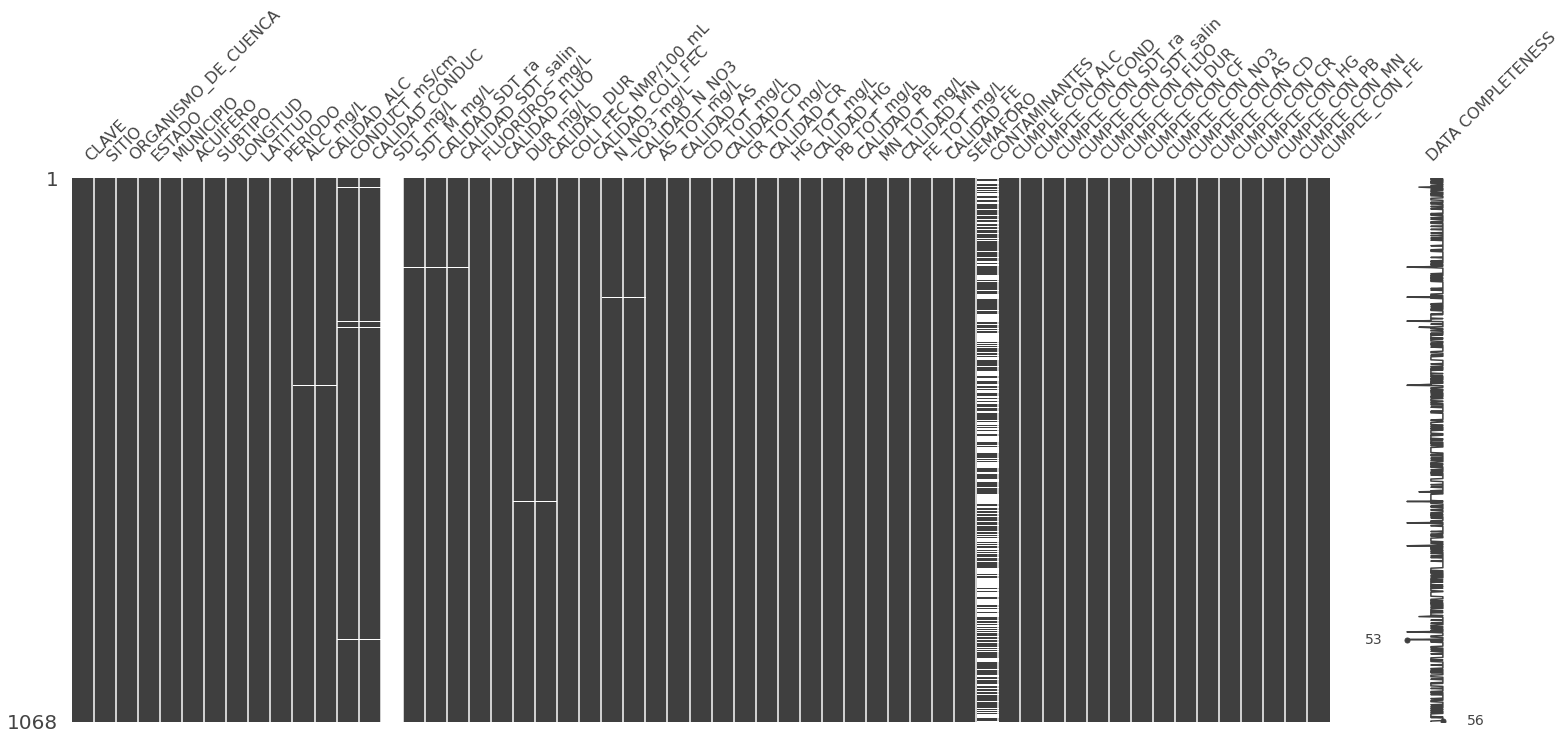

In [13]:
msno.matrix(df_sub, labels=list(df_sub.columns))
plt.show()

## Distribucion de datos contiuos

### Histogramas

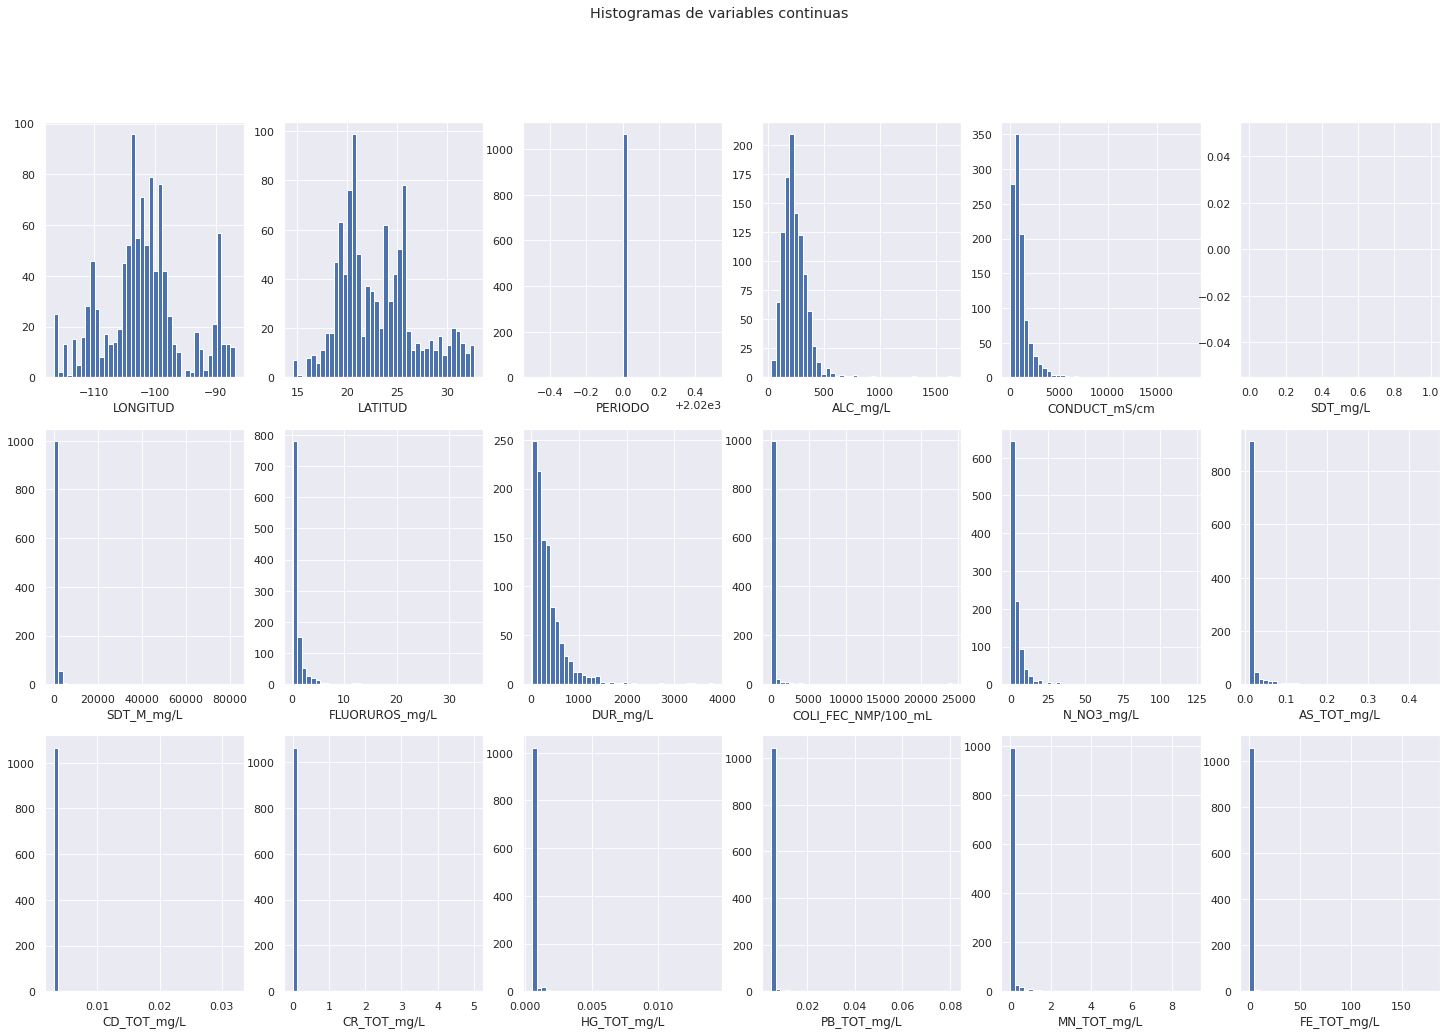

In [14]:
sns.set(rc={'figure.figsize':(25,16)})
i = 0
fig, axes = plt.subplots(3, 6)    
for col in float_columns:
  plt.subplot(3,6,i+1)    
  plt.hist(df_sub[col].dropna(), bins=40)   
  plt.xlabel(col)
  i+=1

fig.suptitle('Histogramas de variables continuas')
plt.show()

### Boxplots

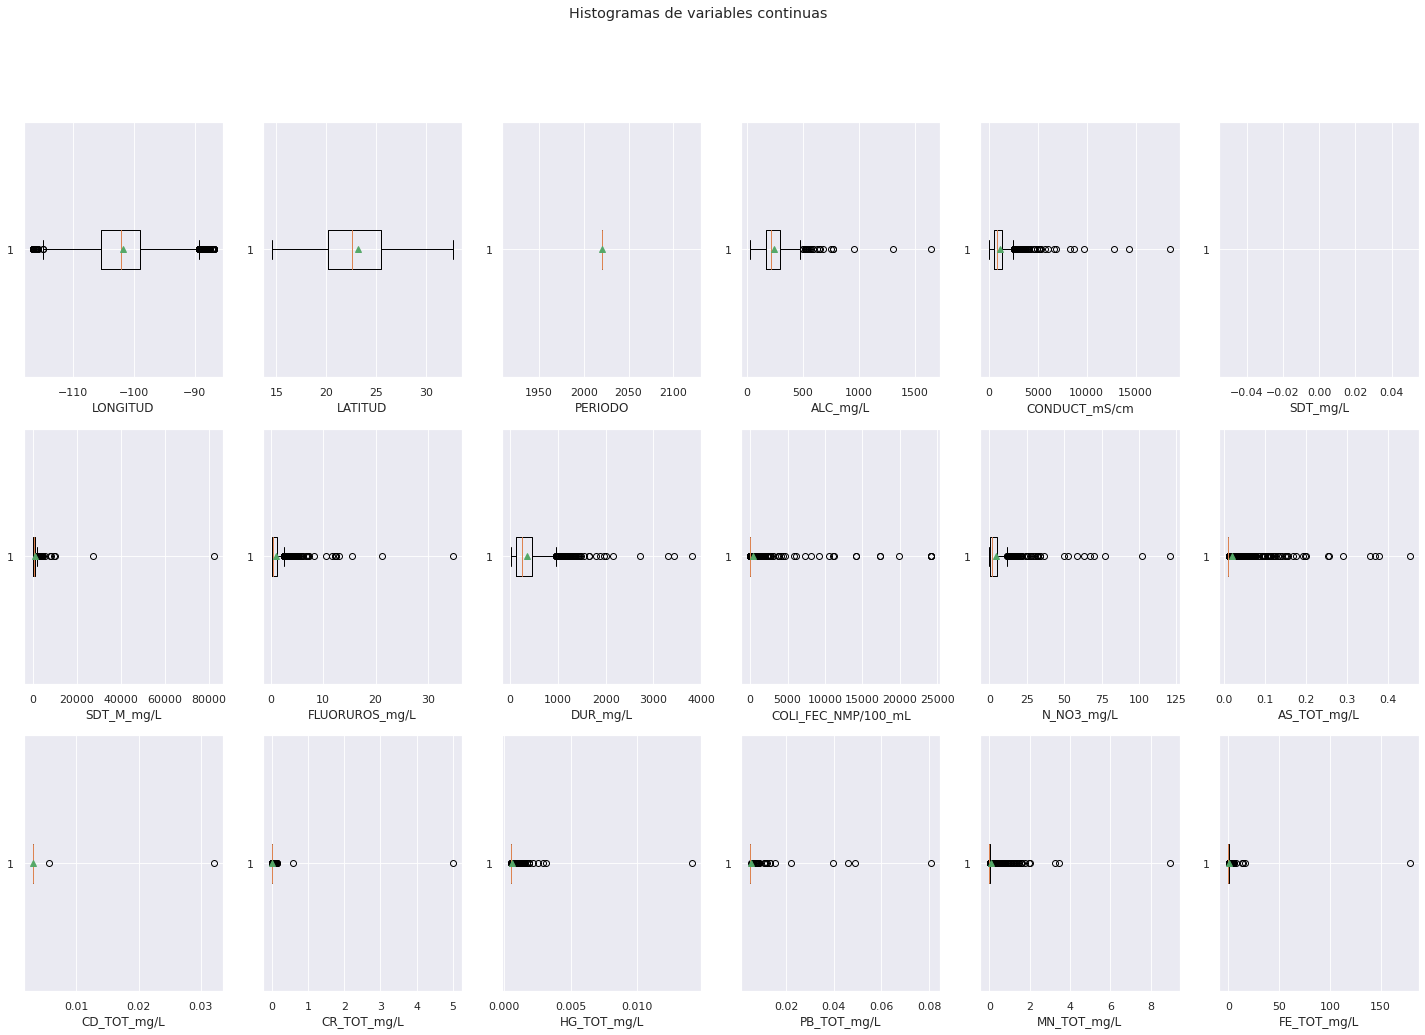

In [15]:
sns.set(rc={'figure.figsize':(25,16)})
i = 0
fig, axes = plt.subplots(3, 6)    
for col in float_columns:
  plt.subplot(3,6,i+1)    
  plt.boxplot(df_sub[col].dropna(), showmeans=True, vert=False)   
  plt.xlabel(col)
  i+=1

fig.suptitle('Histogramas de variables continuas')
plt.show()

### Boxplots por semaforo

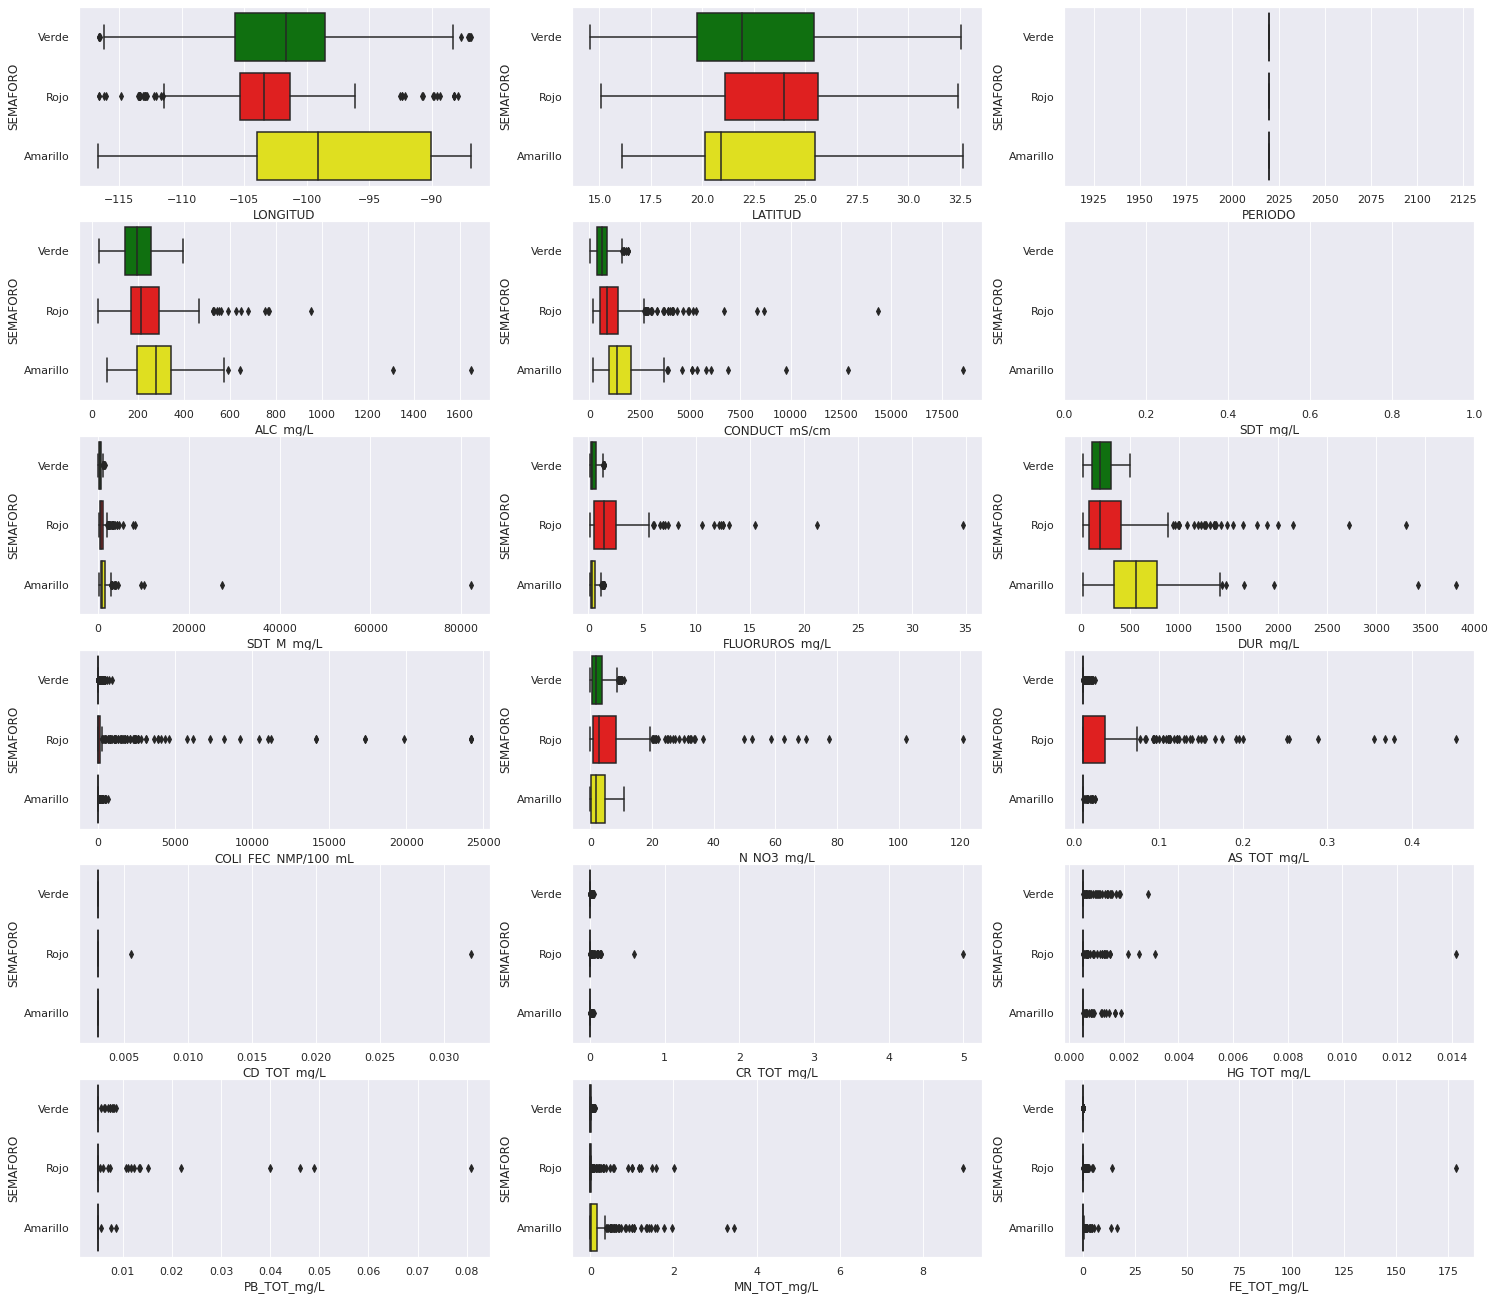

In [16]:
sns.set(rc={'figure.figsize':(25,23)})
fig, axes = plt.subplots(6, 3)    
i = 0

for col in float_columns:
    plt.subplot(6,3,i+1) 
    sns.boxplot(y='SEMAFORO',
                x=col,
                data=df_sub,
                orient='horizontal',
                palette=colors_palete)
    plt.xlabel(col)
    i+=1

## Contaminantes

Conteo de contaminates para cada dato

In [17]:
#esto lo hacemos para convertir la lista de contaminantes a un número entero mediante conteo.
#NaN significa que no tiene contaminantes
for row in df_sub.index:
  try:
    df_sub.at[row,"CONTAMINANTES"] = len(df_sub.loc[row]["CONTAMINANTES"])
  except:
    pass

#Conversion de NaN a 0
df_sub['CONTAMINANTES'].fillna(value = 0, inplace=True)
df_sub["CONTAMINANTES"] = df_sub["CONTAMINANTES"].astype(int)

## Contaminantes por semaforo

In [18]:
#Evaluamos la cantidad de contaminantes, se evidencia que la clase verde en el semáforo no tiene contaminantes.

df_contamientes = df_sub.groupby(['SEMAFORO'], as_index=False).agg({'CONTAMINANTES':'sum'})
df_contamientes

,SEMAFORO,CONTAMINANTES
0,Amarillo,1969
1,Rojo,3627
2,Verde,0


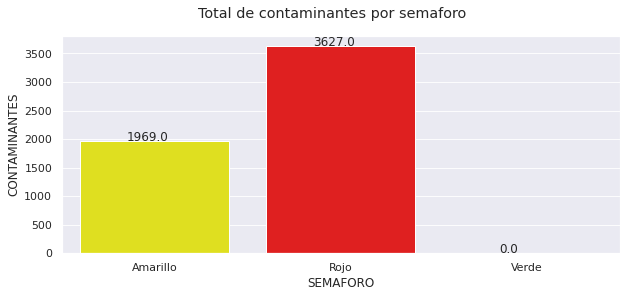

In [19]:
fig, ax = plt.subplots(figsize=(10,4))

ax = sns.barplot(data=df_contamientes, x='SEMAFORO', y='CONTAMINANTES', palette=['yellow','red', 'green'])

for p in ax.patches:
  ax.annotate(p.get_height(), (p.get_x()+0.25,p.get_height()+5))

fig.suptitle('Total de contaminantes por semaforo')
plt.show()

## Dataframe acondicionado

In [20]:
#en una nueva variable reemplazamos las palabras por números para realizar un mejor tratamiento de la información
df_sub['SEMAFORO_cat'] = df_sub['SEMAFORO'].replace({'Verde':1,
                                                     'Amarillo':2,
                                                     'Rojo':3})

df_sub['SEMAFORO_cat'] = df_sub['SEMAFORO_cat'].astype(int)

#eliminamos las variables que no aportan al análisis
df_sub_clean = df_sub.drop(['SEMAFORO', 'PERIODO', 'SDT_mg/L'], axis=1)

In [21]:
clean_float_columns = [col for col in df_sub_clean.columns if df_sub_clean[col].dtypes != object]
print(len(clean_float_columns), clean_float_columns)

18 ['LONGITUD', 'LATITUD', 'ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CD_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L', 'CONTAMINANTES', 'SEMAFORO_cat']


### Visualizacion de dataframe acondicionado

In [22]:
clean_color_list = ['green','yellow','red']
clean_colors_palete = sns.color_palette(clean_color_list)

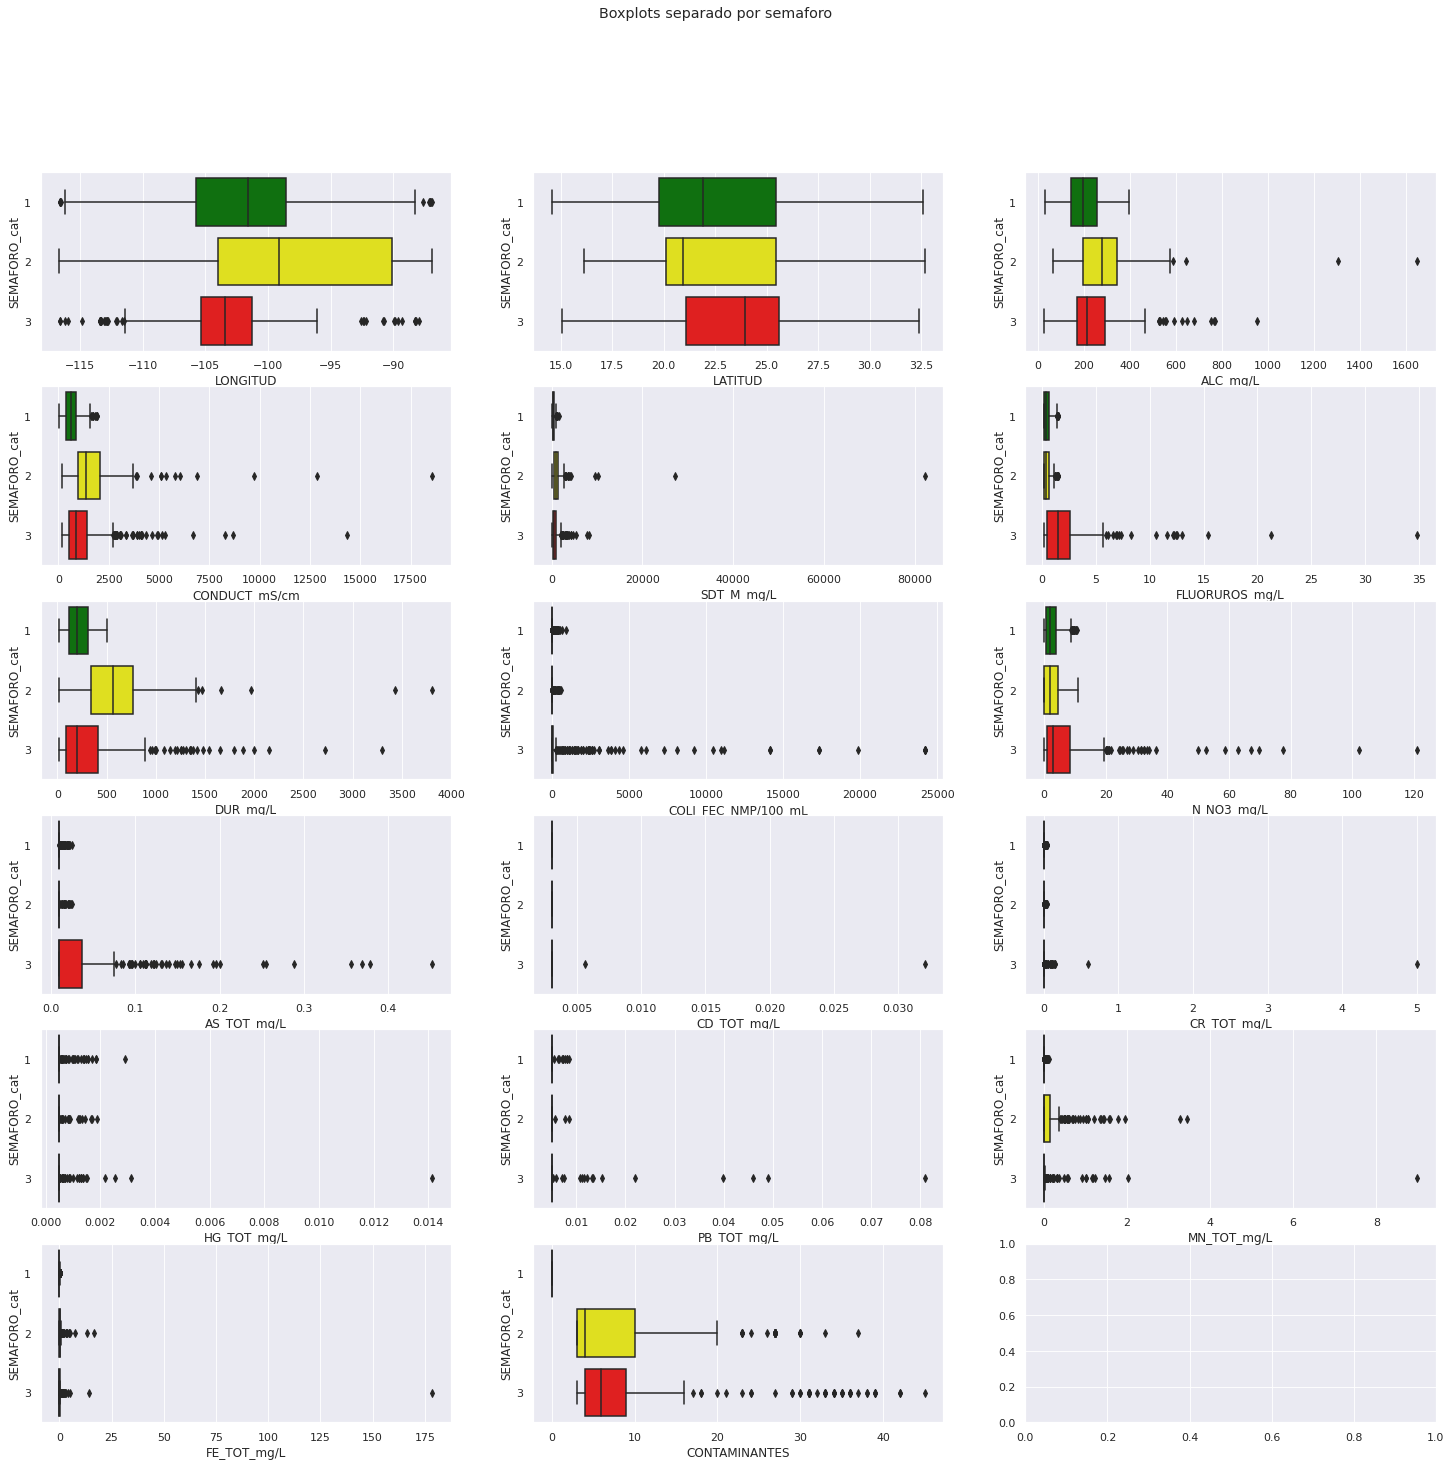

------------------------ 


In [23]:
sns.set(rc={'figure.figsize':(25,23)})
fig, axes = plt.subplots(6, 3)    
i = 0

for col in clean_float_columns[:-1]:
  plt.subplot(6,3,i+1) 
  sns.boxplot(y='SEMAFORO_cat',
              x=col,
              data=df_sub,
              orient='horizontal',
              palette=clean_colors_palete)
  plt.xlabel(col)
  i+=1

fig.suptitle('Boxplots separado por semaforo')
plt.show()
print("------------------------ ")

Revisamos la correlacion entre las variables numericas

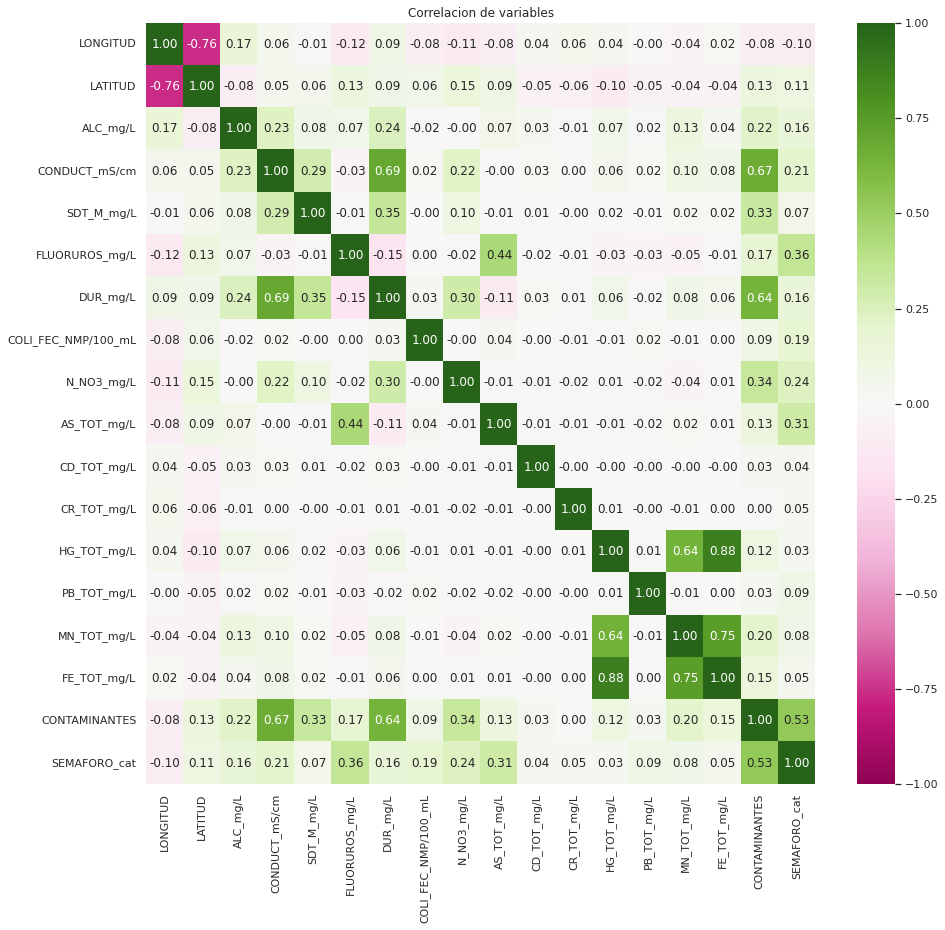

In [24]:
sns.set(rc={'figure.figsize':(15,14)}) 

sns.heatmap(df_sub_clean.corr(method='pearson'), cmap='PiYG', annot=True, fmt='.2f', vmin=-1, vmax=1)

plt.title('Correlacion de variables')
plt.show()

Existe alta correlacio con la cantidad de contamiantes y el codigo de semaforo

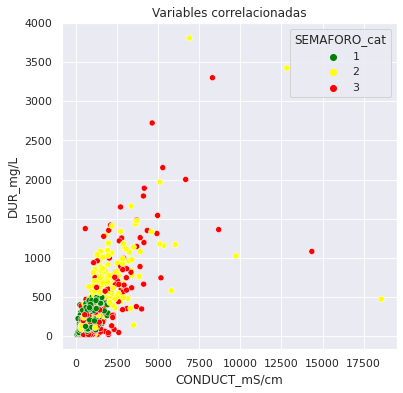

In [25]:
sns.set(rc={'figure.figsize':(6,6)})
sns.scatterplot(x=df_sub_clean['CONDUCT_mS/cm'], y=df_sub_clean['DUR_mg/L'], hue=df_sub_clean['SEMAFORO_cat'], palette=clean_colors_palete)

plt.title('Variables correlacionadas')
plt.show()

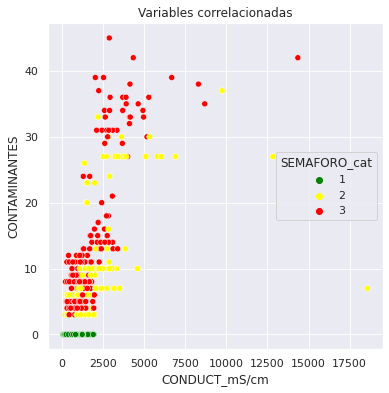

In [26]:
sns.set(rc={'figure.figsize':(6,6)})
sns.scatterplot(x=df_sub_clean['CONDUCT_mS/cm'], y=df_sub_clean['CONTAMINANTES'], hue=df_sub_clean['SEMAFORO_cat'], palette=clean_colors_palete)

plt.title('Variables correlacionadas')
plt.show()

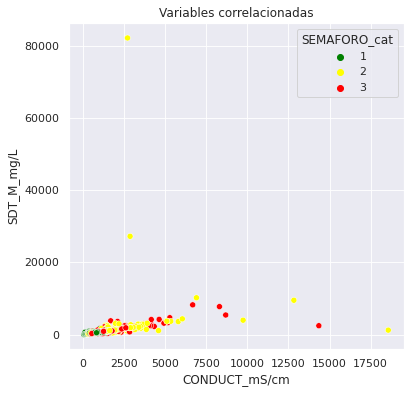

In [27]:
sns.set(rc={'figure.figsize':(6,6)})
sns.scatterplot(x=df_sub_clean['CONDUCT_mS/cm'], y=df_sub_clean['SDT_M_mg/L'], hue=df_sub_clean['SEMAFORO_cat'], palette=clean_colors_palete)

plt.title('Variables correlacionadas')
plt.show()

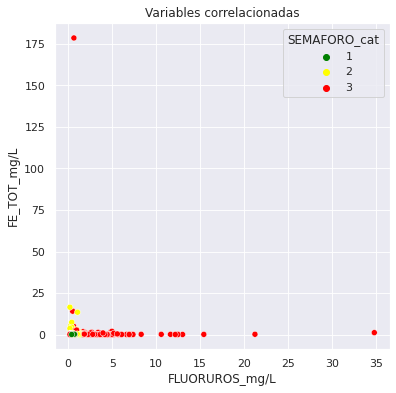

In [28]:
sns.set(rc={'figure.figsize':(6,6)})
sns.scatterplot(x=df_sub_clean['FLUORUROS_mg/L'], y=df_sub_clean['FE_TOT_mg/L'], hue=df_sub_clean['SEMAFORO_cat'], palette=clean_colors_palete)

plt.title('Variables correlacionadas')
plt.show()

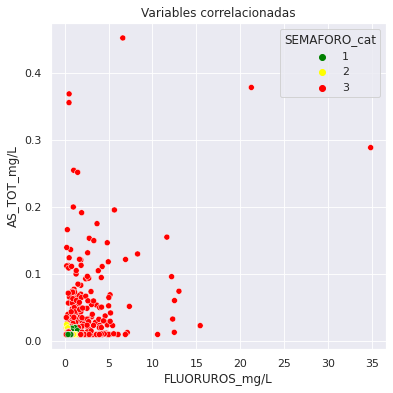

In [29]:
sns.set(rc={'figure.figsize':(6,6)})
sns.scatterplot(x=df_sub_clean['FLUORUROS_mg/L'], y=df_sub_clean['AS_TOT_mg/L'], hue=df_sub_clean['SEMAFORO_cat'], palette=clean_colors_palete)

plt.title('Variables correlacionadas')
plt.show()

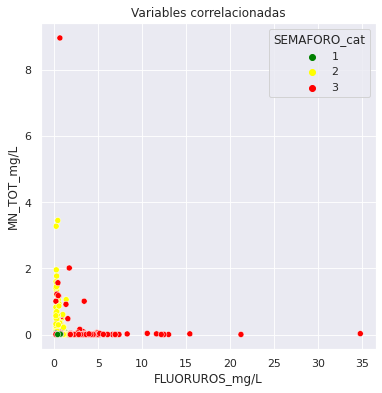

In [30]:
sns.set(rc={'figure.figsize':(6,6)})
sns.scatterplot(x=df_sub_clean['FLUORUROS_mg/L'], y=df_sub_clean['MN_TOT_mg/L'], hue=df_sub_clean['SEMAFORO_cat'], palette=clean_colors_palete)

plt.title('Variables correlacionadas')
plt.show()

Vamos a graficar las coordenadas

In [31]:
fig = px.scatter_mapbox(df_sub_clean,
                        title='Aguas subterraneas por semaforo',
                        lat='LATITUD',
                        lon='LONGITUD',
                        hover_name='SITIO',
                        hover_data=['ORGANISMO_DE_CUENCA','MUNICIPIO', 'SEMAFORO_cat'],
                        color=df_sub_clean['SEMAFORO_cat'].astype(str),
                        color_discrete_map={'1': 'green', '2':'yellow', '3':'red'},
                        opacity=0.3,
                        zoom=4,
                        height=800,
                        width=800)

fig.update_layout(title_x=0.5, title_y=0.98, mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [32]:
print(categorical_columns[2:22])

['ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO', 'ACUIFERO', 'SUBTIPO', 'CALIDAD_ALC', 'CALIDAD_CONDUC', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'CALIDAD_FLUO', 'CALIDAD_DUR', 'CALIDAD_COLI_FEC', 'CALIDAD_N_NO3', 'CALIDAD_AS', 'CALIDAD_CD', 'CALIDAD_CR', 'CALIDAD_HG', 'CALIDAD_PB', 'CALIDAD_MN', 'CALIDAD_FE']


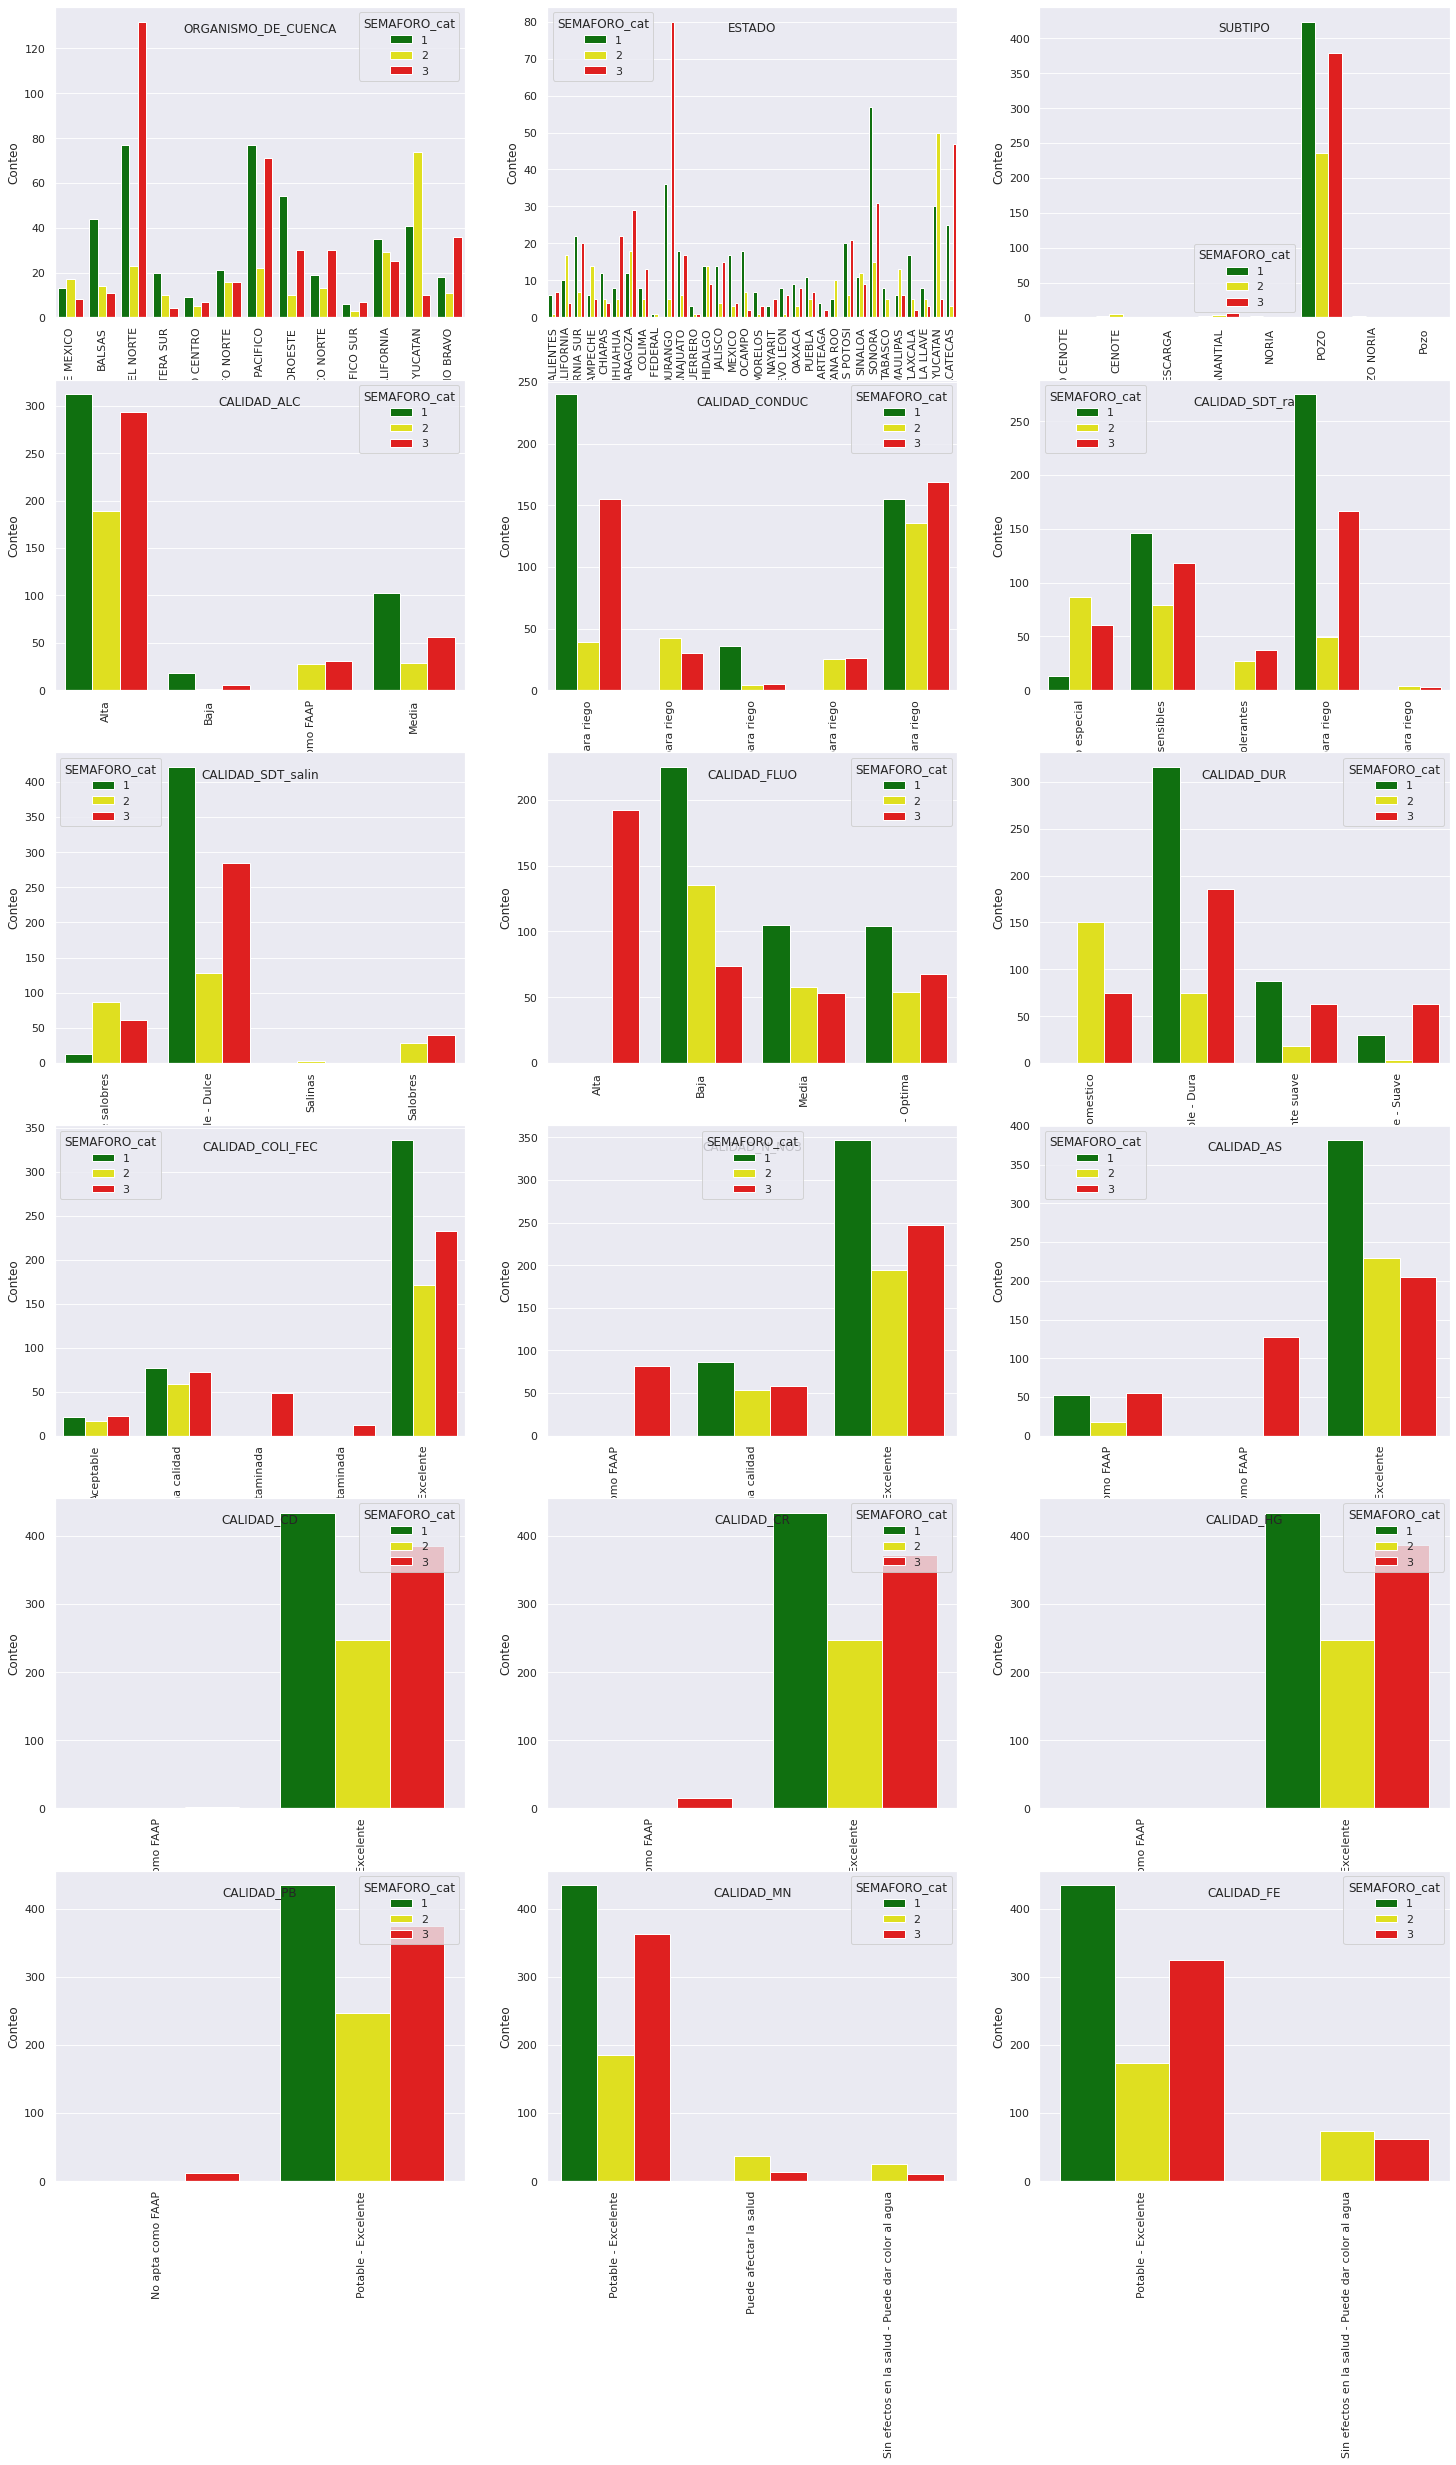

In [33]:
clean_color_list = ['green','yellow','red']

sns.set(rc={'figure.figsize':(25,40)})
fig, axes = plt.subplots(6, 3)    
i = 0
for categoria in categorical_columns[2:22]:
  
  if (categoria != 'MUNICIPIO') and (categoria != 'ACUIFERO'):
    plt.subplot(6,3,i+1) 
    conteo = pd.DataFrame(df_sub_clean.groupby([categoria,'SEMAFORO_cat'], as_index=False).size())
    sns.barplot(data=conteo ,x=categoria, y='size', hue='SEMAFORO_cat', palette=clean_color_list)

    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('Conteo')
    plt.title(categoria, y=0.9)
    

    i+=1

plt.show()  

#Seleccion de datos para modelo

In [34]:
df_sub_clean.columns[9:-16]

Index(['ALC_mg/L', 'CALIDAD_ALC', 'CONDUCT_mS/cm', 'CALIDAD_CONDUC',
       'SDT_M_mg/L', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'FLUORUROS_mg/L',
       'CALIDAD_FLUO', 'DUR_mg/L', 'CALIDAD_DUR', 'COLI_FEC_NMP/100_mL',
       'CALIDAD_COLI_FEC', 'N_NO3_mg/L', 'CALIDAD_N_NO3', 'AS_TOT_mg/L',
       'CALIDAD_AS', 'CD_TOT_mg/L', 'CALIDAD_CD', 'CR_TOT_mg/L', 'CALIDAD_CR',
       'HG_TOT_mg/L', 'CALIDAD_HG', 'PB_TOT_mg/L', 'CALIDAD_PB', 'MN_TOT_mg/L',
       'CALIDAD_MN', 'FE_TOT_mg/L', 'CALIDAD_FE', 'CONTAMINANTES'],
      dtype='object')

In [35]:
df_nonNAN = df_sub_clean.dropna()
df_nonNAN.reset_index(drop=True, inplace=True)

X = df_nonNAN.iloc[:,9:-16]
y = df_nonNAN['SEMAFORO_cat']

X_float_columns = [col for col in X.columns if X[col].dtypes != object]
X_cat_columns = [col for col in X.columns if X[col].dtypes == object]

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ALC_mg/L             1054 non-null   float64
 1   CALIDAD_ALC          1054 non-null   object 
 2   CONDUCT_mS/cm        1054 non-null   float64
 3   CALIDAD_CONDUC       1054 non-null   object 
 4   SDT_M_mg/L           1054 non-null   float64
 5   CALIDAD_SDT_ra       1054 non-null   object 
 6   CALIDAD_SDT_salin    1054 non-null   object 
 7   FLUORUROS_mg/L       1054 non-null   float64
 8   CALIDAD_FLUO         1054 non-null   object 
 9   DUR_mg/L             1054 non-null   float64
 10  CALIDAD_DUR          1054 non-null   object 
 11  COLI_FEC_NMP/100_mL  1054 non-null   float64
 12  CALIDAD_COLI_FEC     1054 non-null   object 
 13  N_NO3_mg/L           1054 non-null   float64
 14  CALIDAD_N_NO3        1054 non-null   object 
 15  AS_TOT_mg/L          1054 non-null   f

In [37]:
len(y)

1054

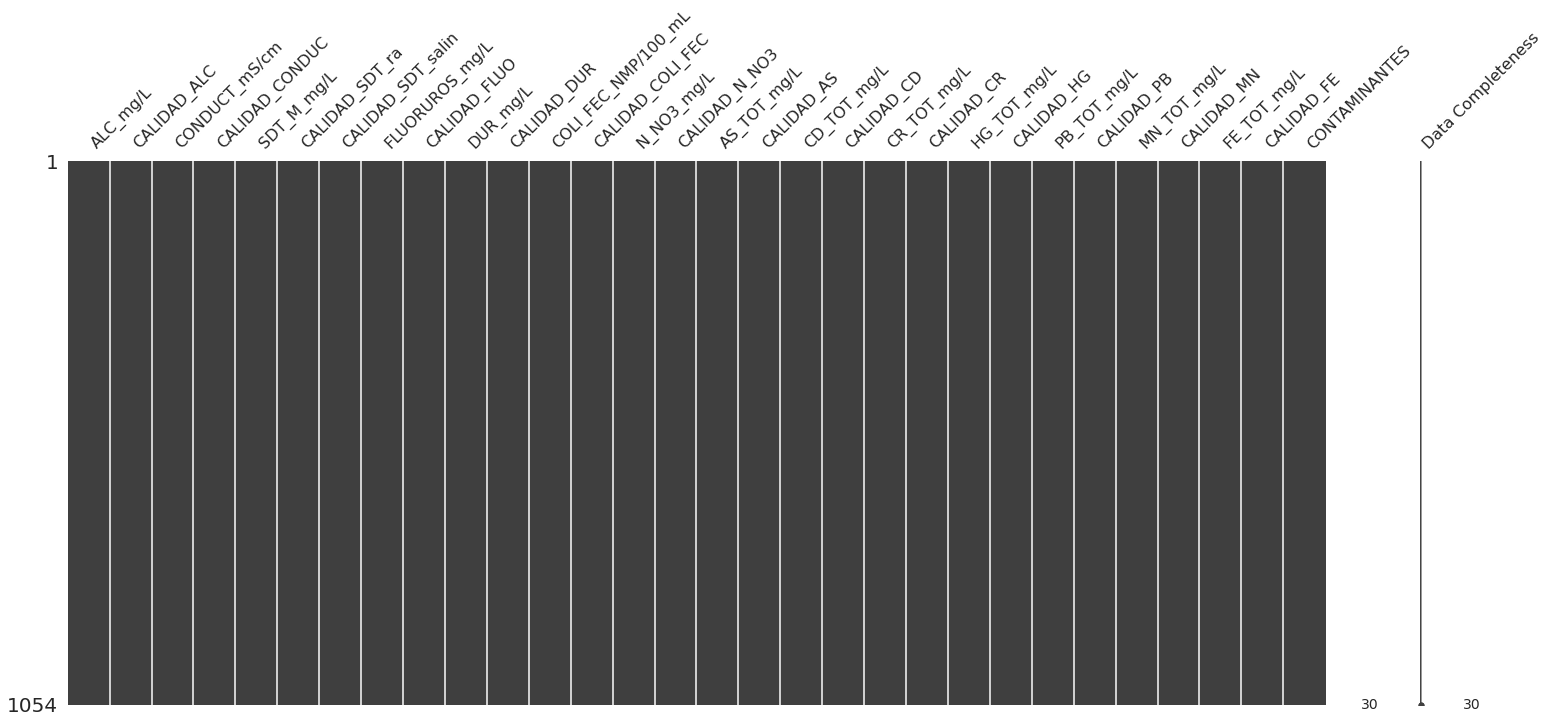

In [38]:
msno.matrix(X, labels=list(X.columns))
plt.show()

In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
label_encoder = LabelEncoder()
X_coded = pd.DataFrame()

list_code_clases = {}

for cat in X_cat_columns:
  X_coded[cat] = label_encoder.fit_transform(X[cat]).astype(int)
  list_code_clases[cat] = label_encoder.classes_

X_coded = pd.concat([X[X_float_columns],X_coded], axis=1)

In [41]:
X_coded.sample(3)

,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,...,CALIDAD_DUR,CALIDAD_COLI_FEC,CALIDAD_N_NO3,CALIDAD_AS,CALIDAD_CD,CALIDAD_CR,CALIDAD_HG,CALIDAD_PB,CALIDAD_MN,CALIDAD_FE
974,215.83,1102.0,723.0,0.4691,607.870,1.1,3.080400,0.0100,0.003,0.0164,...,0,4,2,2,1,1,1,1,0,0
570,177.60,585.0,345.0,1.4074,121.512,41.0,2.635581,0.0151,0.003,0.0050,...,1,1,2,0,1,1,1,1,0,0
853,229.00,1173.0,980.0,4.1817,80.822,1.1,1.710679,0.0203,0.003,0.0085,...,2,4,2,0,1,1,1,1,0,0


In [42]:
list_code_clases.items()

dict_items([('CALIDAD_ALC', array(['Alta', 'Baja', 'Indeseable como FAAP', 'Media'], dtype=object)), ('CALIDAD_CONDUC', array(['Buena para riego', 'Dudosa para riego', 'Excelente para riego',
       'Indeseable para riego', 'Permisible para riego'], dtype=object)), ('CALIDAD_SDT_ra', array(['Cultivos con manejo especial', 'Cultivos sensibles',
       'Cultivos tolerantes', 'Excelente para riego',
       'Indeseable para riego'], dtype=object)), ('CALIDAD_SDT_salin', array(['Ligeramente salobres', 'Potable - Dulce', 'Salinas', 'Salobres'],
      dtype=object)), ('CALIDAD_FLUO', array(['Alta', 'Baja', 'Media', 'Potable - Optima'], dtype=object)), ('CALIDAD_DUR', array(['Muy dura e indeseable usos industrial y domestico',
       'Potable - Dura', 'Potable - Moderadamente suave',
       'Potable - Suave'], dtype=object)), ('CALIDAD_COLI_FEC', array(['Aceptable', 'Buena calidad', 'Contaminada',
       'Fuertemente contaminada', 'Potable - Excelente'], dtype=object)), ('CALIDAD_N_NO3', array

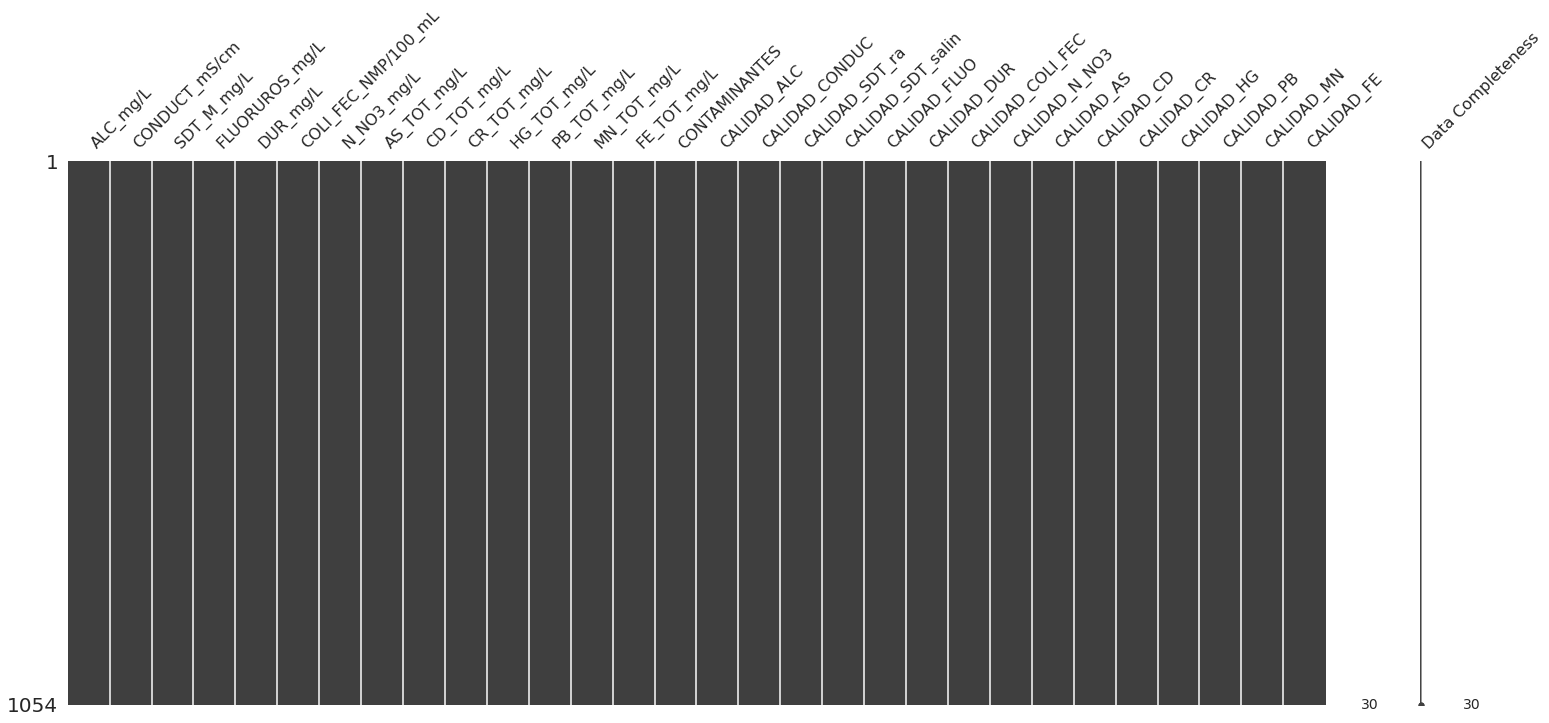

In [43]:
msno.matrix(X_coded, labels=list(X_coded.columns))
plt.show()

#Division del data set para entrenamiento y validacion

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_coded, y, test_size=test_size, random_state=0, stratify=y)

#Transformacion de datos continuos

In [46]:
def log_mas_1(x_var):
  return np.log(x_var+1)

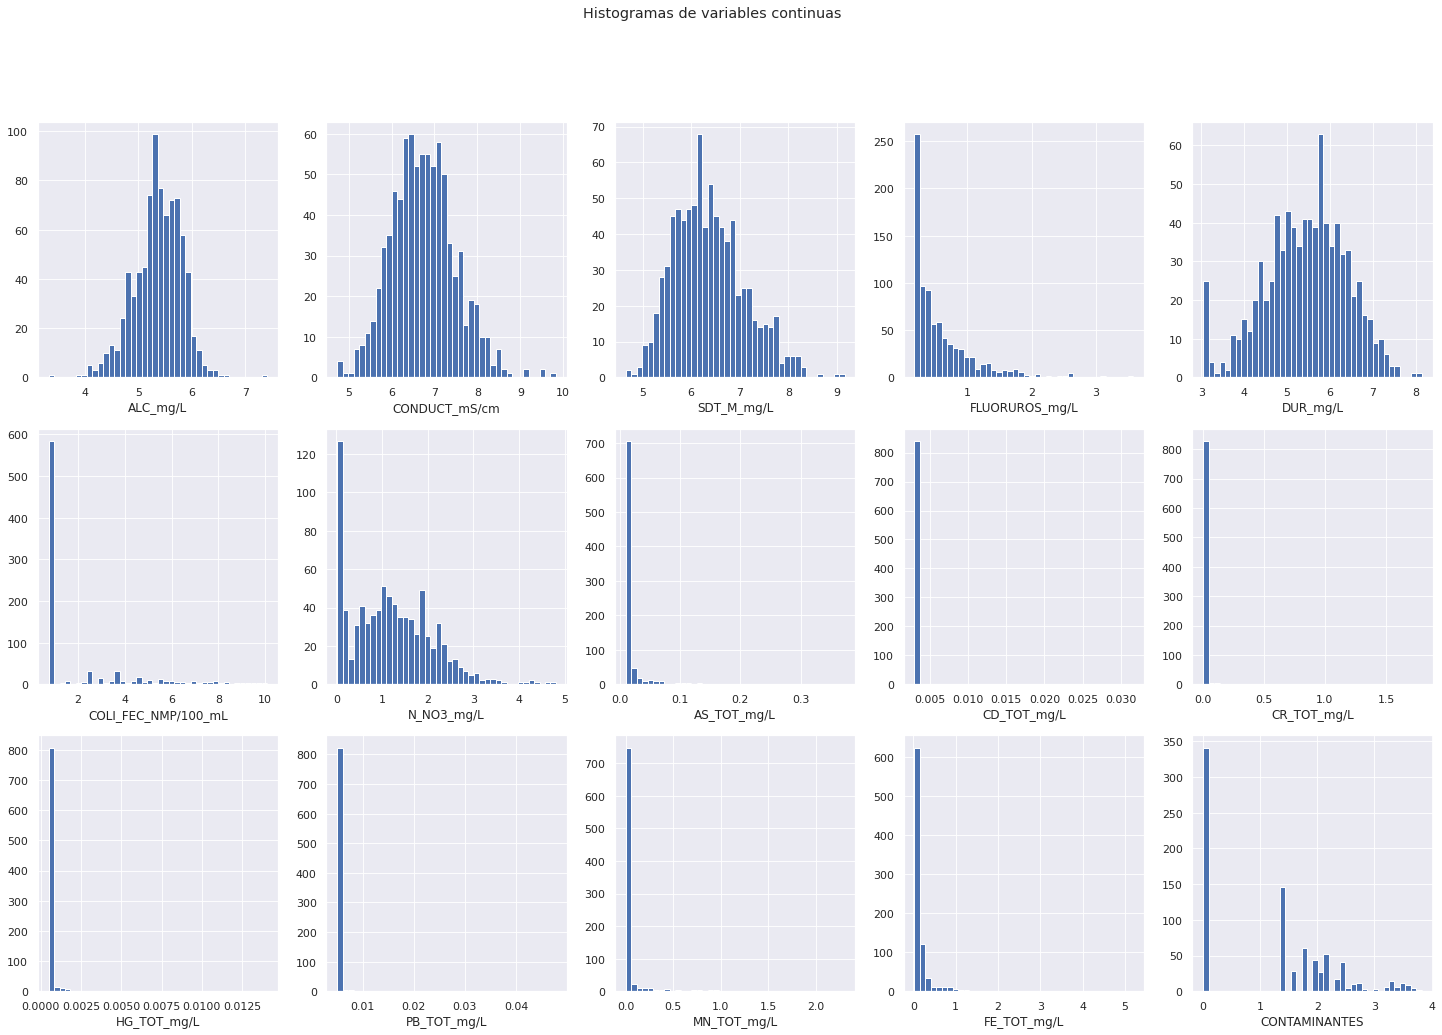

In [47]:

sns.set(rc={'figure.figsize':(25,16)})
i = 0
fig, axes = plt.subplots(3, 5)    
for col in X_float_columns:
  plt.subplot(3,5,i+1)    
  plt.hist(log_mas_1(X_train[col].dropna()), bins=40)   
  plt.xlabel(col)
  i+=1

fig.suptitle('Histogramas de variables continuas')
plt.show()

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

## Pipeline para transformacion

In [49]:
num_pipeline = Pipeline(steps = [('impMean', SimpleImputer(strategy='mean')),
                                 ('log', FunctionTransformer(log_mas_1))
                                 ])
num_pipeline_nombres = X_float_columns


cat_pipeline = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])
cat_pipeline_nombres = X_cat_columns


columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipeline, num_pipeline_nombres),
                                                        ('catpipe', cat_pipeline, cat_pipeline_nombres)
                                                        ])

#Modelos

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, make_scorer
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, cross_validate, GridSearchCV

import time
import re

In [51]:
metricas = {
      'accuracy': make_scorer(accuracy_score),
      'f1-score': make_scorer(f1_score),
      'precision':make_scorer(precision_score),
      'recall': make_scorer(recall_score),
      'gmean': make_scorer(geometric_mean_score, greater_is_better=True, average='binary')
            }

## Arbol de desicion

In [52]:
model_DT= DecisionTreeClassifier(random_state = 37)

In [53]:
pipeline_DT = Pipeline(steps=[('ct', columnasTransformer), ('m', model_DT)])

dicc_grid = {'m__ccp_alpha':[0,0.001,0.01,0.01, 0.1], 
             'm__criterion':['gini', 'entropy'],
             'm__max_depth':[3,5,7,11], 
             'm__min_samples_split': [2,3,4,5,7], 
             'm__class_weight':['balanced', None]}  

cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state = 37)

grid_DecisionTree = GridSearchCV(estimator=pipeline_DT, 
                                 param_grid=dicc_grid, 
                                 cv=cv,
                                 return_train_score=True,
                                 scoring = make_scorer(accuracy_score),
                                 n_jobs = -1)

In [54]:
start_time = time.time()
grid_DecisionTree.fit(X_train, np.ravel(y_train))
end_time = time.time()

print(f"Execution time: {end_time - start_time: .2f} seconds \n")

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid_DecisionTree.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid_DecisionTree.best_params_)

Execution time:  199.75 seconds 

Mejor valor de exactitud obtenido con la mejor combinación: 0.9881313473256601
Mejor combinación de valores encontrados de los hiperparámetros: {'m__ccp_alpha': 0, 'm__class_weight': 'balanced', 'm__criterion': 'gini', 'm__max_depth': 7, 'm__min_samples_split': 2}


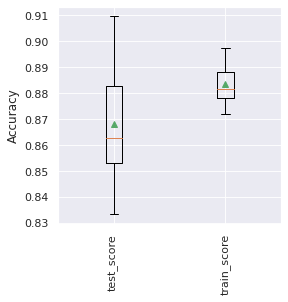

In [55]:
grid_cv_results = pd.DataFrame(grid_DecisionTree.cv_results_)

grupos = ['test','train']
metrica ='score'

mejor_modelo_metricas = {}

for grupo in grupos:
  split = ".*split.*."+grupo+".*"+metrica+".*"
  r = re.compile(split, re.IGNORECASE)
  columns = list(filter(r.match, grid_cv_results.columns))

  mejor_modelo_metricas[grupo+'_'+metrica] = grid_cv_results[columns].values.tolist()


sns.set(rc={'figure.figsize':(4,4)})
c='black'
valores = []
etiquetas = []

for metrica, value in mejor_modelo_metricas.items():
  valores.append(value[0])
  etiquetas.append(metrica)

box1 = plt.boxplot(valores, labels=etiquetas, showmeans=True)

plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.show()

### Metricas de Validacion cruzada

In [56]:
mejor_accuracy_idx = grid_cv_results[['mean_test_score']].idxmax()
best_acc = grid_cv_results.loc[grid_cv_results['mean_test_score']==grid_cv_results['mean_test_score'].max()]

grupos = ['test','train']
metrica ='score'

mejor_modelo_acc = {}

for grupo in grupos:
  split = ".*split.*."+grupo+".*"+metrica+".*"
  r = re.compile(split, re.IGNORECASE)
  columns = list(filter(r.match, best_acc.columns))

  mejor_modelo_acc[grupo+'_'+metrica] = best_acc[columns].values.tolist()

train : 0.9964409982602437 test : 0.9881313473256601


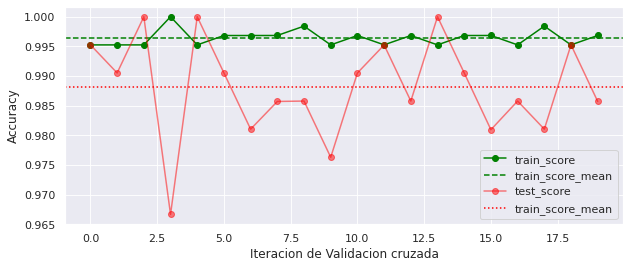

In [57]:
cv_iterations = range(0,20,1)

fig, ax = plt.subplots(figsize=(10,4)) 

plt.plot(cv_iterations, mejor_modelo_acc['train_score'][0], '-o', label='train_score', c='green')
plt.axhline(y = np.mean(mejor_modelo_acc['train_score'][0]), linestyle = 'dashed', label='train_score_mean', color='green')
plt.plot(cv_iterations, mejor_modelo_acc['test_score'][0], '-o', label='test_score', c='red', alpha=0.5)
plt.axhline(y = np.mean(mejor_modelo_acc['test_score'][0]), linestyle = ':', label='train_score_mean', color='red')
plt.legend()
plt.xlabel('Iteracion de Validacion cruzada')
plt.ylabel('Accuracy')
print('train :', np.mean(mejor_modelo_acc['train_score'][0]),
      'test :' , np.mean(mejor_modelo_acc['test_score'][0]))
plt.show()

### Modelo Final DT

In [58]:
#{'m__ccp_alpha': 0, 'm__class_weight': 'balanced', 'm__criterion': 'gini', 'm__max_depth': 7, 'm__min_samples_split': 2}
model_final_DT = DecisionTreeClassifier(ccp_alpha= 0, 
                                        class_weight='balanced', 
                                        criterion= 'gini',
                                        max_depth=7,
                                        min_samples_split= 2,
                                        random_state = 37)

pipeline_DT = Pipeline(steps=[('ct', columnasTransformer), ('m', model_final_DT)])

pipeline_DT.fit(X_train, y_train)

print('Accuracy train final: ', pipeline_DT.score(X_train, np.ravel(y_train)))
print('Accuracy test final: ', pipeline_DT.score(X_test, np.ravel(y_test)))

y_hat = pipeline_DT.predict(X_test)
print('El reporte de Clasificación :\n', classification_report(y_test, y_hat) )

Accuracy train final:  0.99644128113879
Accuracy test final:  1.0
El reporte de Clasificación :
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        86
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        76

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



### Matriz de confusion

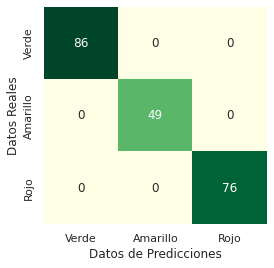

In [59]:
cm=confusion_matrix(y_test, y_hat)
df_cm = pd.DataFrame(cm, index = ['Verde','Amarillo','Rojo'], columns = ['Verde','Amarillo','Rojo'])

plt.figure(figsize = (4,4))
ax = sns.heatmap(df_cm, annot=True, cmap='YlGn', cbar=False)
ax.set(ylabel="Datos Reales", xlabel="Datos de Predicciones")
plt.show()

## Importancia de las variables

In [60]:
df_features = pd.DataFrame(model_final_DT.feature_importances_, index = X_train.columns).sort_values(by=[0], ascending = False)
df_features = df_features.rename(columns={0: "Feature Importance"})

df_features["Acumulado"] = np.cumsum(df_features["Feature Importance"])

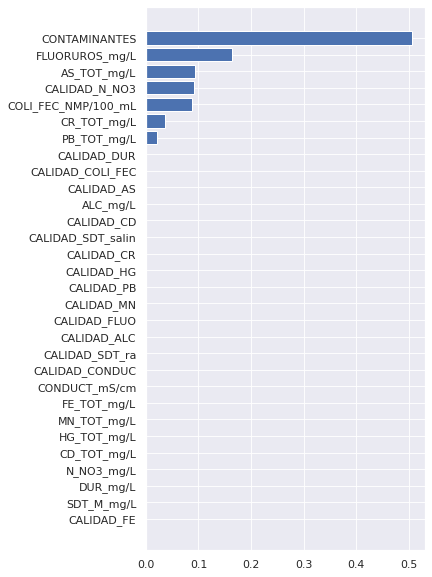

In [61]:
plt.figure(figsize = (5,10))

plt.barh(df_features.index,df_features["Feature Importance"])
plt.gca().invert_yaxis()

plt.show()

In [62]:
variables_mas_importantes = X_coded.copy().drop(columns=df_features[df_features['Feature Importance'] == 0].index)
variables_mas_importantes.head()

,FLUORUROS_mg/L,COLI_FEC_NMP/100_mL,AS_TOT_mg/L,CR_TOT_mg/L,PB_TOT_mg/L,CONTAMINANTES,CALIDAD_N_NO3
0,0.9766,1.1,0.0161,0.005,0.005,0,2
1,0.9298,1.1,0.0134,0.005,0.005,0,1
2,1.8045,1.1,0.0370,0.005,0.005,8,2
3,1.1229,1.1,0.0154,0.005,0.005,0,2
4,0.2343,291.0,0.0100,0.005,0.005,4,0


## Modelo de arbol de desicion con variables mas importantes

In [63]:
X_train, X_test, y_train, y_test = train_test_split(variables_mas_importantes, y, test_size=test_size, random_state=0, stratify=y)

In [64]:
num_pipeline = Pipeline(steps = [('impMean', SimpleImputer(strategy='mean')),
                                 ('log', FunctionTransformer(log_mas_1))
                                 ])
num_pipeline_nombres = list((variables_mas_importantes.columns)&(X_float_columns))


cat_pipeline = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])
cat_pipeline_nombres = list((variables_mas_importantes.columns)&(X_cat_columns))


columnasTransformer_importantes = ColumnTransformer(transformers = [('numpipe', num_pipeline, num_pipeline_nombres),
                                                        ('catpipe', cat_pipeline, cat_pipeline_nombres)
                                                        ])

In [65]:
model_importantes_DT= DecisionTreeClassifier(random_state = 37)

pipeline_importantes_DT = Pipeline(steps=[('ct', columnasTransformer_importantes), ('m', model_importantes_DT)])

dicc_grid = {'m__ccp_alpha':[0,0.001,0.01,0.01, 0.1], 
             'm__criterion':['gini', 'entropy'],
             'm__max_depth':[3,5,7,11], 
             'm__min_samples_split': [2,3,4,5,7], 
             'm__class_weight':['balanced', None]}  

cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state = 37)

grid_importantes_DT = GridSearchCV(estimator=pipeline_importantes_DT, 
                                    param_grid=dicc_grid, 
                                    cv=cv,
                                    return_train_score=True,
                                    scoring = make_scorer(accuracy_score),
                                    n_jobs = -1)

In [66]:
start_time = time.time()
grid_importantes_DT.fit(X_train, np.ravel(y_train))
end_time = time.time()

print(f"Execution time: {end_time - start_time: .2f} seconds \n")

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid_importantes_DT.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid_importantes_DT.best_params_)

Execution time:  162.17 seconds 

Mejor valor de exactitud obtenido con la mejor combinación: 0.9895531482735276
Mejor combinación de valores encontrados de los hiperparámetros: {'m__ccp_alpha': 0, 'm__class_weight': 'balanced', 'm__criterion': 'entropy', 'm__max_depth': 7, 'm__min_samples_split': 2}


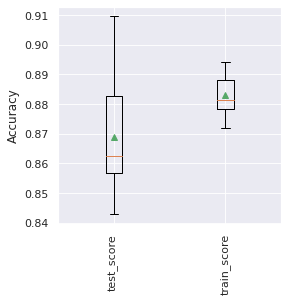

In [67]:
grid_cv_results = pd.DataFrame(grid_importantes_DT.cv_results_)

grupos = ['test','train']
metrica ='score'

mejor_modelo_metricas = {}

for grupo in grupos:
  split = ".*split.*."+grupo+".*"+metrica+".*"
  r = re.compile(split, re.IGNORECASE)
  columns = list(filter(r.match, grid_cv_results.columns))

  mejor_modelo_metricas[grupo+'_'+metrica] = grid_cv_results[columns].values.tolist()


sns.set(rc={'figure.figsize':(4,4)})
c='black'
valores = []
etiquetas = []

for metrica, value in mejor_modelo_metricas.items():
  valores.append(value[0])
  etiquetas.append(metrica)

box1 = plt.boxplot(valores, labels=etiquetas, showmeans=True)

plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.show()

### Metricas de validacion cruzada

train : 0.9962827704121425 test : 0.9895531482735276


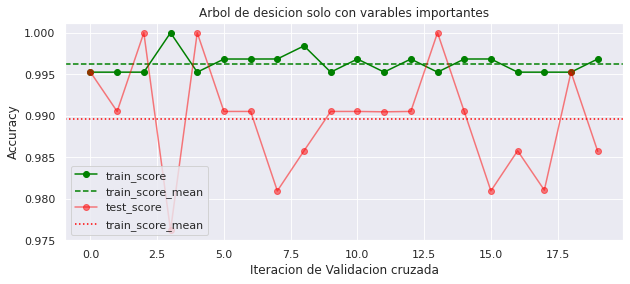

In [68]:
mejor_accuracy_idx = grid_cv_results[['mean_test_score']].idxmax()
best_acc = grid_cv_results.loc[grid_cv_results['mean_test_score']==grid_cv_results['mean_test_score'].max()]

grupos = ['test','train']
metrica ='score'

mejor_modelo_acc = {}

for grupo in grupos:
  split = ".*split.*."+grupo+".*"+metrica+".*"
  r = re.compile(split, re.IGNORECASE)
  columns = list(filter(r.match, best_acc.columns))

  mejor_modelo_acc[grupo+'_'+metrica] = best_acc[columns].values.tolist()


cv_iterations = range(0,20,1)

fig, ax = plt.subplots(figsize=(10,4)) 

plt.plot(cv_iterations, mejor_modelo_acc['train_score'][0], '-o', label='train_score', c='green')
plt.axhline(y = np.mean(mejor_modelo_acc['train_score'][0]), linestyle = 'dashed', label='train_score_mean', color='green')
plt.plot(cv_iterations, mejor_modelo_acc['test_score'][0], '-o', label='test_score', c='red', alpha=0.5)
plt.axhline(y = np.mean(mejor_modelo_acc['test_score'][0]), linestyle = ':', label='train_score_mean', color='red')
plt.legend()
plt.xlabel('Iteracion de Validacion cruzada')
plt.ylabel('Accuracy')
print('train :', np.mean(mejor_modelo_acc['train_score'][0]),
      'test :' , np.mean(mejor_modelo_acc['test_score'][0]))

plt.title('Arbol de desicion solo con varables importantes')
plt.show()

## Modelo Final con variables importates

In [69]:
#{'m__ccp_alpha': 0, 'm__class_weight': 'balanced', 'm__criterion': 'entropy', 'm__max_depth': 7, 'm__min_samples_split': 2}
model_final_DT = DecisionTreeClassifier(ccp_alpha= 0, 
                                        class_weight='balanced', 
                                        criterion= 'entropy',
                                        max_depth=7,
                                        min_samples_split= 2,
                                        random_state = 37)

pipeline_importantes_DT = Pipeline(steps=[('ct', columnasTransformer_importantes), ('m', model_final_DT)])

pipeline_importantes_DT.fit(X_train, y_train)

print('Accuracy train final: ', pipeline_importantes_DT.score(X_train, np.ravel(y_train)))
print('Accuracy test final: ', pipeline_importantes_DT.score(X_test, np.ravel(y_test)))

y_hat = pipeline_importantes_DT.predict(X_test)
print('El reporte de Clasificación :\n', classification_report(y_test, y_hat) )

Accuracy train final:  0.99644128113879
Accuracy test final:  1.0
El reporte de Clasificación :
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        86
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        76

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



### Matriz de confusion

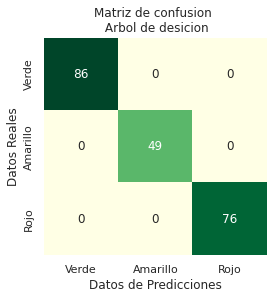

In [70]:
cm=confusion_matrix(y_test, y_hat)
df_cm = pd.DataFrame(cm, index = ['Verde','Amarillo','Rojo'], columns = ['Verde','Amarillo','Rojo'])

plt.figure(figsize = (4,4))
ax = sns.heatmap(df_cm, annot=True, cmap='YlGn', cbar=False)
ax.set(ylabel="Datos Reales", xlabel="Datos de Predicciones" , title='Matriz de confusion \n Arbol de desicion')
plt.show()

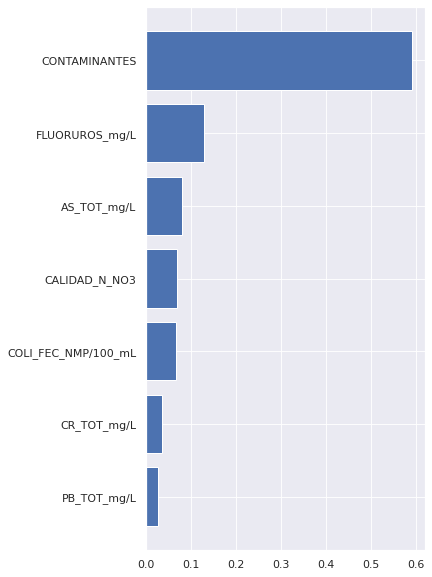

In [71]:
df_features = pd.DataFrame(model_final_DT.feature_importances_, index = X_train.columns).sort_values(by=[0], ascending = False)
df_features = df_features.rename(columns={0: "Feature Importance"})

df_features["Acumulado"] = np.cumsum(df_features["Feature Importance"])

plt.figure(figsize = (5,10))

plt.barh(df_features.index,df_features["Feature Importance"])
plt.gca().invert_yaxis()

plt.show()

### Arbol de desicion

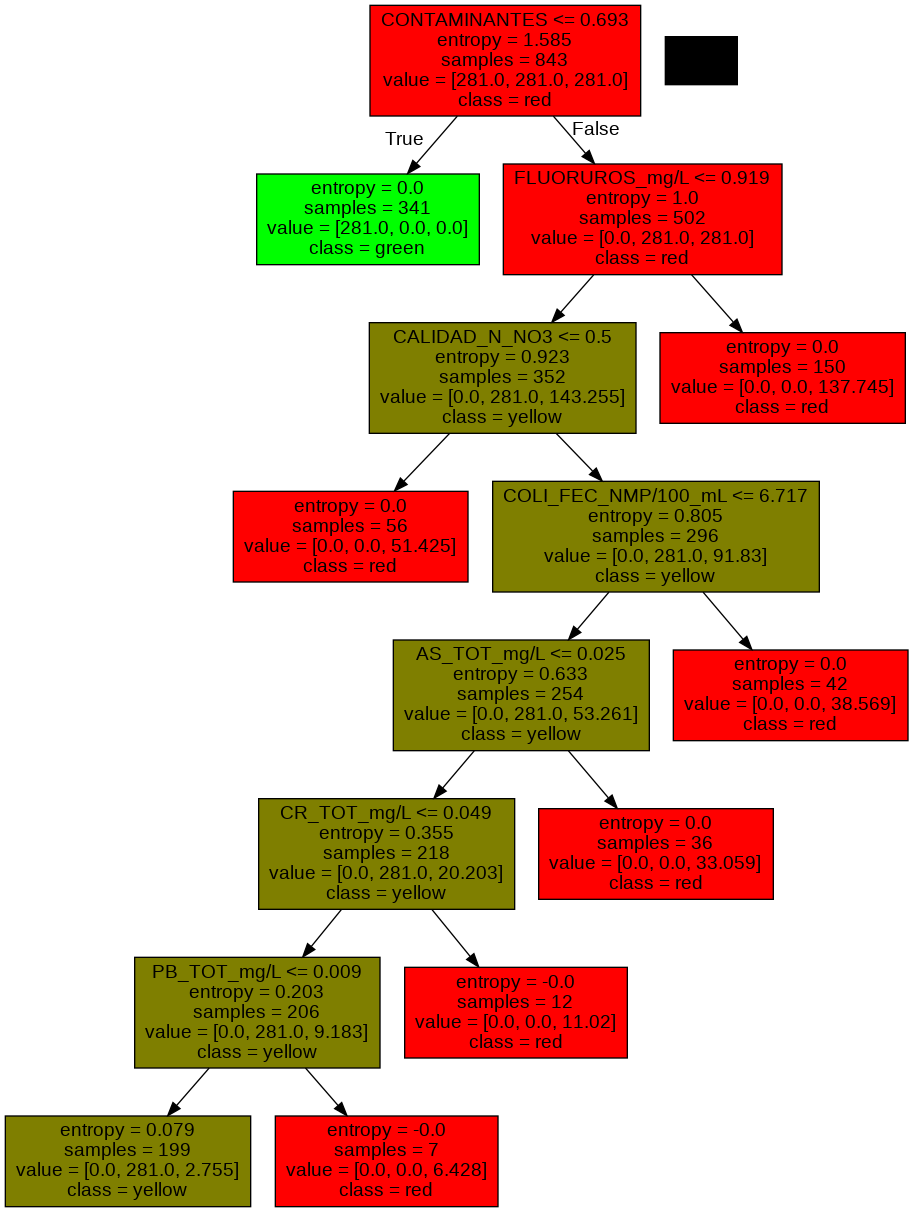

In [115]:
from sklearn import tree
import pydotplus 
from IPython.display import Image
import tempfile
import collections
from matplotlib import colors

dot_data = tree.export_graphviz(decision_tree = model_final_DT,
                                class_names = ['green', 'yellow','red'],
                                feature_names=variables_mas_importantes.columns,
                                filled=True,
                                rotate=False,
                                proportion=False,)

arbol = pydotplus.graph_from_dot_data(dot_data)

nodes = arbol.get_node_list()

for node in nodes:
    if node.get_label():
        values = colors.to_rgb([ii for ii in node.get_label().split('nclass = ')[1].split('"')[0].split(',')][0])
        values = [int(255 * v / sum(values)) for v in values]
        color = '#{:02x}{:02x}{:02x}'.format(values[0], values[1], values[2])
        node.set_fillcolor(color)


Image(arbol.create_png())

# Bosque aleatoreo

In [80]:
model_importantes_RF= RandomForestClassifier(random_state = 37)

pipeline_importantes_RF = Pipeline(steps=[('ct', columnasTransformer_importantes), ('m', model_importantes_RF)])

dicc_grid = {'m__ccp_alpha':[0,0.001,0.01,0.01, 0.1], 
             'm__criterion':['gini', 'entropy'],
             'm__max_depth':[3,5,7,11], 
             'm__min_samples_split': [3,4,5,7], 
             'm__class_weight':['balanced', None]}  

cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state = 37)

grid_importantes_RF = GridSearchCV(estimator=pipeline_importantes_RF, 
                                    param_grid=dicc_grid, 
                                    cv=cv,
                                    return_train_score=True,
                                    scoring = make_scorer(accuracy_score),
                                    n_jobs = -1)

In [81]:
start_time = time.time()
grid_importantes_RF.fit(X_train, np.ravel(y_train))
end_time = time.time()

print(f"Execution time: {end_time - start_time: .2f} seconds \n")

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid_importantes_RF.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid_importantes_RF.best_params_)

Execution time:  754.31 seconds 

Mejor valor de exactitud obtenido con la mejor combinación: 0.9900282103362674
Mejor combinación de valores encontrados de los hiperparámetros: {'m__ccp_alpha': 0, 'm__class_weight': 'balanced', 'm__criterion': 'entropy', 'm__max_depth': 11, 'm__min_samples_split': 3}


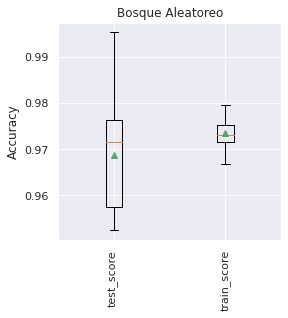

In [82]:
grid_cv_results = pd.DataFrame(grid_importantes_RF.cv_results_)

grupos = ['test','train']
metrica ='score'

mejor_modelo_metricas = {}

for grupo in grupos:
  split = ".*split.*."+grupo+".*"+metrica+".*"
  r = re.compile(split, re.IGNORECASE)
  columns = list(filter(r.match, grid_cv_results.columns))

  mejor_modelo_metricas[grupo+'_'+metrica] = grid_cv_results[columns].values.tolist()


sns.set(rc={'figure.figsize':(4,4)})
c='black'
valores = []
etiquetas = []

for metrica, value in mejor_modelo_metricas.items():
  valores.append(value[0])
  etiquetas.append(metrica)

box1 = plt.boxplot(valores, labels=etiquetas, showmeans=True)

plt.xticks(rotation=90)
plt.title('Bosque Aleatoreo')
plt.ylabel('Accuracy')
plt.show()

train : 0.9969944207810908 test : 0.9900282103362674


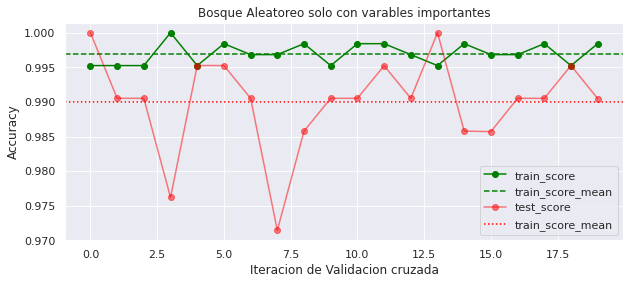

In [83]:
mejor_accuracy_idx = grid_cv_results[['mean_test_score']].idxmax()
best_acc = grid_cv_results.loc[grid_cv_results['mean_test_score']==grid_cv_results['mean_test_score'].max()]

grupos = ['test','train']
metrica ='score'

mejor_modelo_acc = {}

for grupo in grupos:
  split = ".*split.*."+grupo+".*"+metrica+".*"
  r = re.compile(split, re.IGNORECASE)
  columns = list(filter(r.match, best_acc.columns))

  mejor_modelo_acc[grupo+'_'+metrica] = best_acc[columns].values.tolist()


cv_iterations = range(0,20,1)

fig, ax = plt.subplots(figsize=(10,4)) 

plt.plot(cv_iterations, mejor_modelo_acc['train_score'][0], '-o', label='train_score', c='green')
plt.axhline(y = np.mean(mejor_modelo_acc['train_score'][0]), linestyle = 'dashed', label='train_score_mean', color='green')
plt.plot(cv_iterations, mejor_modelo_acc['test_score'][0], '-o', label='test_score', c='red', alpha=0.5)
plt.axhline(y = np.mean(mejor_modelo_acc['test_score'][0]), linestyle = ':', label='train_score_mean', color='red')
plt.legend()
plt.xlabel('Iteracion de Validacion cruzada')
plt.ylabel('Accuracy')
print('train :', np.mean(mejor_modelo_acc['train_score'][0]),
      'test :' , np.mean(mejor_modelo_acc['test_score'][0]))

plt.title('Bosque Aleatoreo solo con varables importantes')
plt.show()

## Modelo Final RF

In [84]:
#{'m__ccp_alpha': 0, 'm__class_weight': 'balanced', 'm__criterion': 'entropy', 'm__max_depth': 11, 'm__min_samples_split': 3}
model_final_RF = RandomForestClassifier(ccp_alpha= 0, 
                                        class_weight='balanced', 
                                        criterion='entropy', 
                                        max_depth=11,
                                        min_samples_split= 3,
                                        random_state = 37)

pipeline_importantes_RF = Pipeline(steps=[('ct', columnasTransformer_importantes), ('m', model_final_RF)])

pipeline_importantes_RF.fit(X_train, y_train)

print('Accuracy train final: ', pipeline_importantes_RF.score(X_train, np.ravel(y_train)))
print('Accuracy test final: ', pipeline_importantes_RF.score(X_test, np.ravel(y_test)))

y_hat = pipeline_importantes_RF.predict(X_test)
print('El reporte de Clasificación :\n', classification_report(y_test, y_hat) )

Accuracy train final:  0.99644128113879
Accuracy test final:  1.0
El reporte de Clasificación :
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        86
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        76

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



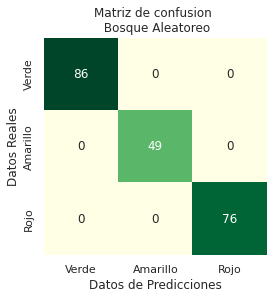

In [85]:
cm=confusion_matrix(y_test, y_hat)
df_cm = pd.DataFrame(cm, index = ['Verde','Amarillo','Rojo'], columns = ['Verde','Amarillo','Rojo'])

plt.figure(figsize = (4,4))
ax = sns.heatmap(df_cm, annot=True, cmap='YlGn', cbar=False)
ax.set(ylabel="Datos Reales", xlabel="Datos de Predicciones", title='Matriz de confusion \n Bosque Aleatoreo')
plt.show()

#end